In [52]:
# https://medium.com/codex/algorithmic-trading-with-bollinger-bands-in-python-1b0a00c9ef99

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [54]:
df = pd.read_csv(f"C:\\Users\Grant\Desktop\work_git\work\old\data\\1d\ENSUSDT_1d.csv", index_col='Time')
df.index = pd.to_datetime(df.index)

In [55]:
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

df['sma_20'] = sma(df['Close'], 20)
df.tail()

,Open,High,Low,Close,Volume,sma_20
Time,,,,,,
2022-04-22,14.52,15.15,14.01,14.19,964081.01,15.4880
2022-04-23,14.20,14.29,13.77,13.96,422069.15,15.1400
2022-04-24,13.96,15.50,13.85,15.32,1369633.79,14.9145
2022-04-25,15.32,15.90,14.32,15.71,2126280.93,14.7580
2022-04-26,15.73,16.66,14.02,14.34,1821107.47,14.6655


In [56]:
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

df['upper_bb'], df['lower_bb'] = bb(df['Close'], df['sma_20'], 20)
df.tail()

,Open,High,Low,Close,Volume,sma_20,upper_bb,lower_bb
Time,,,,,,,,
2022-04-22,14.52,15.15,14.01,14.19,964081.01,15.4880,19.596905,11.379095
2022-04-23,14.20,14.29,13.77,13.96,422069.15,15.1400,18.403863,11.876137
2022-04-24,13.96,15.50,13.85,15.32,1369633.79,14.9145,17.325881,12.503119
2022-04-25,15.32,15.90,14.32,15.71,2126280.93,14.7580,16.370681,13.145319
2022-04-26,15.73,16.66,14.02,14.34,1821107.47,14.6655,16.138520,13.192480


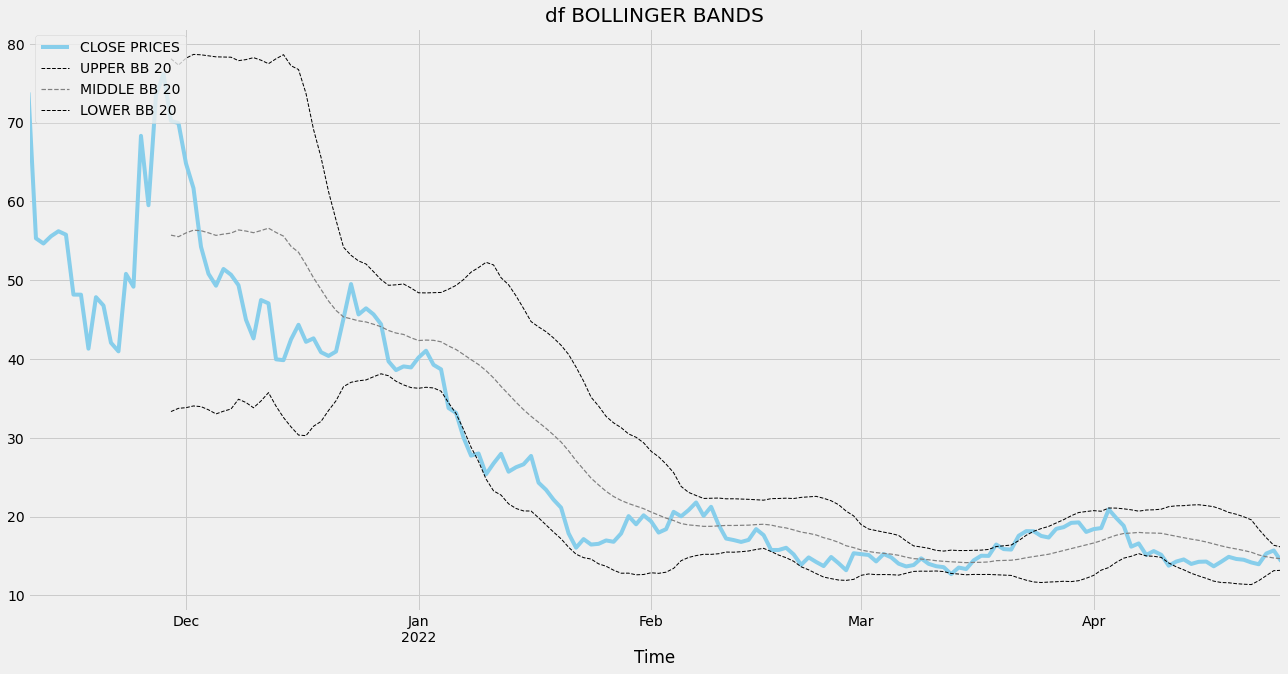

In [57]:
df['Close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
df['upper_bb'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
df['sma_20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
df['lower_bb'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc = 'upper left')
plt.title('df BOLLINGER BANDS')
plt.show()

In [58]:
def implement_bb_strategy(df_close, upper_bb):

    BBBi = [] #bolinger band breakout index
    BBBv = [] #bolinger band breakout value
    entries = [] #the first value that is bigger than the breakout
    entries_Index = [] #the index of entries

    entriesWITHindex = []
    
    for i in range(len(df)):
        if df_close[i] > upper_bb[i]:
            BBBi.append(df.index[i])
            BBBv.append(df_close[i])
    
    for i in range(len(BBBi)):
        for entry_value in df_close[BBBi[i]:]:
            if BBBv[i] < entry_value:
                entries.append(entry_value)
    
                entry_index=df_close.loc[df_close == entry_value].index.values[0]
                entries_Index.append(entry_index)

                entriesWITHindex.append((entry_value, entry_index))

                # print(f"breakout {BBBv[i]}, at {BBBi[i]}")
                # print(f"entry {entry_value}, at {entry_index}")

                diff =str(entry_index - BBBi[i])
                diff = int(diff.split(" ")[0])
                # print((diff))


                # remove entries that are more than 4 days apart of breakout signal
                # less than 0 is because i found a -82 days!!
                if diff > 4 or diff < 0:
                    del entries[-1]
                    del entries_Index[-1]

                break
        # print('\n')

    return BBBv, BBBi, entries, entries_Index, entriesWITHindex
      

BBBv, BBBi, entries, entries_Index, entriesWITHindex = implement_bb_strategy(df['Close'], df['upper_bb'])

In [59]:
# remove signal that are next to each other 
def remove_neighbors(entries_Index ):
    neighbors = []

    for i in range(len(entries_Index)-1):
        s=str(pd.to_datetime(entries_Index[i+1]) - pd.to_datetime(entries_Index[i]))
        s=int(s.split(" ")[0])

        if s <= 3:
            # neighbors.append(i)
            neighbors.append(entries_Index[i+1])


    for n in list(neighbors):
        # print(n)
        if n in entries_Index:
            entries_Index.remove(n)
        

    # entries = [n for n in neighbors if not determine(x)]


    # print(neighbors)
    # print(len(entries))
    print(len(entries_Index))

    return neighbors

# remove_neighbors(entries_Index)


In [60]:
# strategy1: sell after 5% profit








In [61]:

# # Volume Plot
# fig.add_trace(go.Bar(x = df['datetime'], y = df['volume'], showlegend=False), 
#               row = 2, col = 1)
import plotly.graph_objects as go

# plot the candlesticks
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df.Open, 
                                     high=df.High,
                                     low=df.Low,
                                     close=df.Close), 
                      go.Scatter(x=df.index, y=df['sma_20'], line=dict(color='orange', width=1)),
                      go.Scatter(x=df.index, y=df['upper_bb'], line=dict(color='green', width=1)),
                      go.Scatter(x=df.index, y=df['lower_bb'], line=dict(color='green', width=1))])


for b in entries_Index:
    # b is of type np_datetime64, it wont work with plotly
    # so you have to transform it into pandas datetime
    b= pd.to_datetime(b)

    fig.add_vline(x=b, line_width=1, line_dash="dash", line_color="green")


fig.update_layout(template = 'plotly_dark')
fig.layout.xaxis.rangeslider.visible = False


fig.show()

